In [15]:
import readability

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import codecs
import statsmodels.formula.api as smf
import statsmodels.api as sm # import statsmodels
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ProjectiveDependencyParser
from nltk.parse import (
     DependencyGraph,
     ProjectiveDependencyParser,
    NonprojectiveDependencyParser,
)
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.model_selection import train_test_split



## Bring in Data

In [3]:
#challenge_df = pd.read_csv('train_bodies.csv',index_col=False) # Too specific 
#print('Fake News Challenge (Shape):', challenge_df.shape)

#http://www.kdnuggets.com/2017/04/machine-learning-fake-news-accuracy.html
kd_df = pd.read_csv('../data/fake_or_real_news.csv',index_col=0, encoding="utf-8")
print('Fake News KD Nugget Solution (Shape):', kd_df.shape)

#kaggle_df = pd.read_csv('../fake.csv')
#print('Kaggle Fake News Dataset (shape):', kaggle_df.shape)
kd_df['labelint'] = kd_df.label.map({'FAKE':0,'REAL':1})
kd_df.head()


('Fake News KD Nugget Solution (Shape):', (6335, 3))


title  \
8476                        You Can Smell Hillary’s Fear   
10294  Watch The Exact Moment Paul Ryan Committed Pol...   
3608         Kerry to go to Paris in gesture of sympathy   
10142  Bernie supporters on Twitter erupt in anger ag...   
875     The Battle of New York: Why This Primary Matters   

                                                    text label  labelint  
8476   Daniel Greenfield, a Shillman Journalism Fello...  FAKE         0  
10294  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE         0  
3608   U.S. Secretary of State John F. Kerry said Mon...  REAL         1  
10142  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE         0  
875    It's primary day in New York and front-runners...  REAL         1

## Generate Punctuation Counts and add to data

In [4]:
import nltk
from collections import Counter
from collections import defaultdict
import codecs


def get_upper_dicts(t):
    upper_dict = defaultdict(int)
    for w in nltk.word_tokenize(t):
        if w.upper() == w and w.isalpha() and len(w) > 1:
            upper_dict[w] += 1
    return upper_dict
            
def punctuation_counts(t, punc):
    punc_count = 0
    inQuotes = False
    for l in t:
        if l == "\"":
            if inQuotes:
                inQuotes = False
            else:
                inQuotes = True
            continue

        if l == punc and inQuotes is False:
            punc_count +=1
            
    return punc_count

kd_df['QuestionCount'] = kd_df.text.apply(lambda x : punctuation_counts(x , "?"))
kd_df['ExclamationCount'] = kd_df.text.apply(lambda x : punctuation_counts(x , "!"))
kd_df['Word'] = kd_df.text.apply(get_upper_dicts)

In [5]:
kd_df.describe()

labelint  QuestionCount  ExclamationCount
count  6335.000000    6335.000000       6335.000000
mean      0.500552       1.388950          0.480505
std       0.500039       3.900759          2.237809
min       0.000000       0.000000          0.000000
25%       0.000000       0.000000          0.000000
50%       1.000000       0.000000          0.000000
75%       1.000000       1.000000          0.000000
max       1.000000     117.000000        104.000000

## Bring in Sentiment Scores

In [6]:
sentiments = pd.read_csv('../data/sentiments.csv',index_col=0, sep = ',')

In [7]:
sentiments.head()

label    X1   avgsent
title                                                                   
:                                                   FAKE  9694 -0.246154
'America Has Lost' in the Philippines as Dutert...  FAKE  8830 -0.700000
'America is already great': Obama urges US to b...  REAL  5079  0.172414
'America is already strong': Obama continues De...  REAL  5060  0.979592
'American Sniper' widow: Gun control won't prot...  REAL  2332 -0.748201

## Calculate readability scores

In [16]:
readability_df = pd.DataFrame()

for i, r in kd_df.iterrows():  
    this_index = i
    this_text = r['text'].encode("utf-8")
    if pd.isnull(this_text) or this_text.strip() =='':
        continue
    with open("tmp", 'wb') as f:
        f.write(this_text)

    
    read_row = readability.getdataframe(['tmp'])
    read_row['text_index'] = this_index
    readability_df = readability_df.append(read_row, ignore_index=False)

In [17]:
readability_df.head()
readability_df = readability_df.set_index([readability_df.text_index])

## Merge original data + punctuation with readability scores

In [18]:
# join read scores and original thing
scores_full = kd_df.merge(readability_df, left_index=True, right_index= True)

In [19]:
scores_full.head()


title  \
8476                        You Can Smell Hillary’s Fear   
10294  Watch The Exact Moment Paul Ryan Committed Pol...   
3608         Kerry to go to Paris in gesture of sympathy   
10142  Bernie supporters on Twitter erupt in anger ag...   
875     The Battle of New York: Why This Primary Matters   

                                                    text label  labelint  \
8476   Daniel Greenfield, a Shillman Journalism Fello...  FAKE         0   
10294  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE         0   
3608   U.S. Secretary of State John F. Kerry said Mon...  REAL         1   
10142  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE         0   
875    It's primary day in New York and front-runners...  REAL         1   

       QuestionCount  ExclamationCount  \
8476               3                 0   
10294              0                 0   
3608               0                 0   
10142              0                 1   
875                0                 0   

                                                    Word        ARI  \
8476   {u'CNN': 2, u'DOJ': 2, u'FBI': 29, u'KGB': 3, ...  20.756175   
10294                             {u'ABC': 1, u'DNC': 1}  25.782921   
3608                                                  {}  24.953194   
10142                   {u'GOP': 2, u'DNC': 2, u'PM': 1}  18.932743   
875                                          {u'GOP': 1}  14.291074   

       Coleman-Liau  DaleChallIndex     ...      sentences_per_paragraph  \
8476      10.246656       11.307008     ...                         32.0   
10294     10.997259       12.043616     ...                          9.0   
3608      11.049786       11.666903     ...                          1.0   
10142     13.734244       13.362198     ...                          6.5   
875        9.026880       11.235112     ...                          1.0   

       subordination  syll_per_word  syllables  tobeverb  type_token_ratio  \
8476               1       1.400602       1860        62          0.417922   
10294              1       1.465934        667        16          0.630769   
3608               0       1.448747        636         9          0.553531   
10142              2       1.607229        667         9          0.600000   
875                1       1.274924        422         8          0.549849   

       words  words_per_sentence  wordtypes  text_index  
8476    1328           41.500000        555        8476  
10294    455           50.555556        287       10294  
3608     439           48.777778        243        3608  
10142    415           31.923077        249       10142  
875      331           30.090909        182         875  

[5 rows x 40 columns]

## Merge scores, punct, data with sentiment scores

In [28]:
regress = scores_full.merge(sentiments, left_index=True, right_on="X1")
regress = regress.set_index([regress.text_index])

In [29]:
regress.head()

title  \
text_index                                                      
8476                             You Can Smell Hillary’s Fear   
10294       Watch The Exact Moment Paul Ryan Committed Pol...   
3608              Kerry to go to Paris in gesture of sympathy   
10142       Bernie supporters on Twitter erupt in anger ag...   
875          The Battle of New York: Why This Primary Matters   

                                                         text label_x  \
text_index                                                              
8476        Daniel Greenfield, a Shillman Journalism Fello...    FAKE   
10294       Google Pinterest Digg Linkedin Reddit Stumbleu...    FAKE   
3608        U.S. Secretary of State John F. Kerry said Mon...    REAL   
10142       — Kaydee King (@KaydeeKing) November 9, 2016 T...    FAKE   
875         It's primary day in New York and front-runners...    REAL   

            labelint  QuestionCount  ExclamationCount  \
text_index                                              
8476               0              3                 0   
10294              0              0                 0   
3608               1              0                 0   
10142              0              0                 1   
875                1              0                 0   

                                                         Word        ARI  \
text_index                                                                 
8476        {u'CNN': 2, u'DOJ': 2, u'FBI': 29, u'KGB': 3, ...  20.756175   
10294                                  {u'ABC': 1, u'DNC': 1}  25.782921   
3608                                                       {}  24.953194   
10142                        {u'GOP': 2, u'DNC': 2, u'PM': 1}  18.932743   
875                                               {u'GOP': 1}  14.291074   

            Coleman-Liau  DaleChallIndex    ...     syllables  tobeverb  \
text_index                                  ...                           
8476           10.246656       11.307008    ...          1860        62   
10294          10.997259       12.043616    ...           667        16   
3608           11.049786       11.666903    ...           636         9   
10142          13.734244       13.362198    ...           667         9   
875             9.026880       11.235112    ...           422         8   

            type_token_ratio  words  words_per_sentence  wordtypes  \
text_index                                                           
8476                0.417922   1328           41.500000        555   
10294               0.630769    455           50.555556        287   
3608                0.553531    439           48.777778        243   
10142               0.600000    415           31.923077        249   
875                 0.549849    331           30.090909        182   

            text_index  label_y     X1   avgsent  
text_index                                        
8476              8476     FAKE   8476 -1.586207  
10294            10294     FAKE  10294 -0.631579  
3608              3608     REAL   3608 -0.277778  
10142            10142     FAKE  10142 -0.100000  
875                875     REAL    875  1.272727  

[5 rows x 43 columns]

## Write regression data to file

In [31]:
regress.to_csv("RealFakeRegression.csv", encoding = "utf-8")

## Alternatively, bring regression set in directly

In [32]:
regress = pd.read_csv('../data/RealFakeRegression.csv',index_col=0, sep = ',')

In [33]:
regress.head()

title  \
text_index                                                      
8476                             You Can Smell Hillary’s Fear   
10294       Watch The Exact Moment Paul Ryan Committed Pol...   
3608              Kerry to go to Paris in gesture of sympathy   
10142       Bernie supporters on Twitter erupt in anger ag...   
875          The Battle of New York: Why This Primary Matters   

                                                         text label_x  \
text_index                                                              
8476        Daniel Greenfield, a Shillman Journalism Fello...    FAKE   
10294       Google Pinterest Digg Linkedin Reddit Stumbleu...    FAKE   
3608        U.S. Secretary of State John F. Kerry said Mon...    REAL   
10142       — Kaydee King (@KaydeeKing) November 9, 2016 T...    FAKE   
875         It's primary day in New York and front-runners...    REAL   

            labelint  QuestionCount  ExclamationCount  \
text_index                                              
8476               0              3                 0   
10294              0              0                 0   
3608               1              0                 0   
10142              0              0                 1   
875                1              0                 0   

                                                         Word        ARI  \
text_index                                                                 
8476        {u'CNN': 2, u'DOJ': 2, u'FBI': 29, u'KGB': 3, ...  20.756175   
10294                                  {u'ABC': 1, u'DNC': 1}  25.782921   
3608                                                       {}  24.953194   
10142                        {u'GOP': 2, u'DNC': 2, u'PM': 1}  18.932743   
875                                               {u'GOP': 1}  14.291074   

            Coleman-Liau  DaleChallIndex    ...     syllables  tobeverb  \
text_index                                  ...                           
8476           10.246656       11.307008    ...          1860        62   
10294          10.997259       12.043616    ...           667        16   
3608           11.049786       11.666903    ...           636         9   
10142          13.734244       13.362198    ...           667         9   
875             9.026880       11.235112    ...           422         8   

            type_token_ratio  words  words_per_sentence  wordtypes  \
text_index                                                           
8476                0.417922   1328           41.500000        555   
10294               0.630769    455           50.555556        287   
3608                0.553531    439           48.777778        243   
10142               0.600000    415           31.923077        249   
875                 0.549849    331           30.090909        182   

            text_index.1  label_y     X1   avgsent  
text_index                                          
8476                8476     FAKE   8476 -1.586207  
10294              10294     FAKE  10294 -0.631579  
3608                3608     REAL   3608 -0.277778  
10142              10142     FAKE  10142 -0.100000  
875                  875     REAL    875  1.272727  

[5 rows x 43 columns]

## Logistic Regression

In [34]:
train, test = train_test_split(regress, test_size = 0.2, stratify = regress.labelint, random_state = 44)

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4893 entries, 3727 to 1618
Data columns (total 43 columns):
title                      4893 non-null object
text                       4893 non-null object
label_x                    4893 non-null object
labelint                   4893 non-null int64
QuestionCount              4893 non-null int64
ExclamationCount           4893 non-null int64
Word                       4893 non-null object
ARI                        4893 non-null float64
Coleman-Liau               4893 non-null float64
DaleChallIndex             4893 non-null float64
FleschReadingEase          4893 non-null float64
GunningFogIndex            4893 non-null float64
Kincaid                    4893 non-null float64
LIX                        4893 non-null float64
RIX                        4893 non-null float64
SMOGIndex                  4893 non-null float64
article                    4893 non-null int64
auxverb                    4893 non-null int64
characters            

In [36]:
logit = smf.logit("labelint ~ avgsent + QuestionCount + ExclamationCount + ARI + DaleChallIndex + GunningFogIndex + FleschReadingEase + SMOGIndex + tobeverb + auxverb + conjunction + complex_words + pronoun", train).fit()
print logit.summary()

Optimization terminated successfully.
         Current function value: 0.573497
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               labelint   No. Observations:                 4893
Model:                          Logit   Df Residuals:                     4879
Method:                           MLE   Df Model:                           13
Date:                Mon, 05 Jun 2017   Pseudo R-squ.:                  0.1726
Time:                        16:19:42   Log-Likelihood:                -2806.1
converged:                       True   LL-Null:                       -3391.6
                                        LLR p-value:                3.236e-242
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             3.2169      0.738      4.358      0.000         1.770     4.664
avgsent 

In [49]:
pred = pd.Series(logit.predict(test))
pred
pred = pred.map(lambda x: "Real" if x >= 0.5 else "Fake")
pred.describe()
y_test = test.labelint.map(lambda x: "Real" if x ==1 else "Fake")

In [50]:
from sklearn.metrics import confusion_matrix
print confusion_matrix(y_test, pred, labels = ["Real", "Fake"])

[[436 176]
 [190 422]]


In [67]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline



metrics.accuracy_score(y_test, pred) 


0.7009803921568627

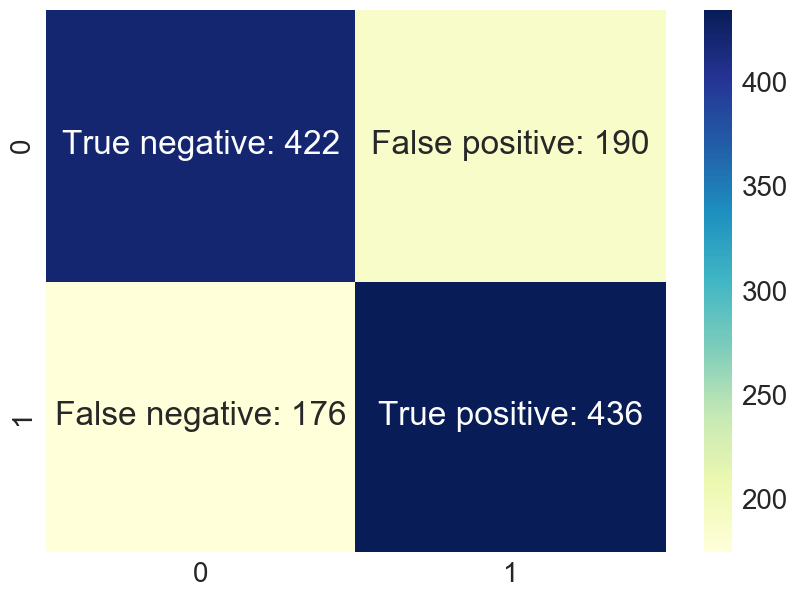

In [64]:
confusion = metrics.confusion_matrix(y_test, pred) 
confusion
ann = np.array([["True negative: ", "False positive: "], ["False negative: ", "True positive: "]])
conf_string = np.char.mod('%d', confusion)
ann = np.core.defchararray.add(ann, conf_string)
plt.figure(figsize = (10,7))

sn.set(font_scale=2)
sn.heatmap(confusion, annot=ann, fmt='', cmap="YlGnBu")


## Multiple Regression

In [26]:
formula = "labelint ~ avgsent + QuestionCount + ExclamationCount + ARI + DaleChallIndex + GunningFogIndex + FleschReadingEase + SMOGIndex + tobeverb + auxverb + conjunction + complex_words + pronoun"
from statsmodels.formula.api import ols
m = ols(formula, regress).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:               labelint   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     85.10
Date:                Mon, 05 Jun 2017   Prob (F-statistic):          2.87e-209
Time:                        10:08:44   Log-Likelihood:                -3930.1
No. Observations:                6117   AIC:                             7888.
Df Residuals:                    6103   BIC:                             7982.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             1.3584      0.11